# Atividade 9 - Classificador Random Forests

# Branch and Bound -  Normalizado

# Algoritmo RandomForestClassifier

● Semelhante aos anteriores, usando Random Forests

● Parâmetros a serem calibrados: <br>
    – mtry / max_features (o parâmetro mais sensível): raiz (quadrada) de n, n sendo o número de características (testar outros) <br>
    – ntree = 500 (quanto maior melhor, depende do tempo disponível)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from pprint import pprint

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing


# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.ensemble import RandomForestClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo Branch and Bound na atividade 4

In [3]:
selecionadas_BB = ['Age','Number of sexual partners',
                   'First sexual intercourse', 'Num of pregnancies',
                   'Smokes (years)','Smokes']


## Pré-Processamento

In [4]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [5]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [6]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [7]:
df_imp = df_processed.copy()

In [8]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## Stratified Cross- Validation

### Dataset Desbalanceado

In [11]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    max_features = grid_params.get('max_features')
    n_estimators = grid_params.get('n_estimators')
    #max_depth = grid_params.get('max_depth')
    #min_samples_split = grid_params.get('min_samples_split')
    #min_samples_leaf = grid_params.get('min_samples_leaf')
    #bootstrap = grid_params.get('bootstrap')
    
    
    # Testa varias max_features
    for mf in max_features:
        print("-> Teste max_features {}".format(mf))
        
        # Testa n_estimators
        for n_estim in n_estimators:
            print("-> Teste n_estimators {}".format(mf))
            
#             # Testa max_depth
#             for md in max_depth:
#                 print("-> Teste max_depth {}".format(md))
                
#                 # Testa min_samples_split
#                 for min_ss in min_samples_split:
#                     print("-> Teste min_samples_split {}".format(min_ss))
                    
#                     # Testa min_samples_leaf
#                     for min_sl in min_samples_leaf:
#                         print("-> Teste min_samples_leaf {}".format(min_sl))
                        
#                         # Testa bootstrap
#                         for bs in bootstrap:
#                             print('\t-> Modelo: max_features ={} | n_estimators {} | max_depth {} | min_samples_split {} | min_samples_leaf {} | bootstrap {}'.format(mf, n_estim, md, min_ss, min_sl, bs))
#                             clf = algoritmo(max_features=mf, n_estimators=n_estim, max_depth=md, min_samples_split=min_ss, min_samples_leaf=min_sl, bootstrap=bs, verbose=0, random_state = random_state)
            print('\t-> Modelo: max_features ={} | n_estimators {}'.format(mf, n_estim))
            pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                 ('clf', algoritmo(max_features=mf, n_estimators=n_estim, verbose=0, random_state = random_state))])

            # Folds
            for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                fold_number = fold
                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                # quantidade de classes dentro da fold
                #REMOVED

                # aplica o classificador
                pipe_clf.fit(X_train, y_train)

                # predict no dataset de treino 
                y_train_preds = pipe_clf.predict(X_train)
                # predict no dataset de teste
                y_pred = pipe_clf.predict(X_test)


                # Scores do model (utilizados dados nao-balanceados) - dados de teste
                recall = recall_score(y_test, y_pred)
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                scores.append([mf, n_estim, fold_number, precision, recall, accuracy]) #md, min_ss, min_sl, bs, fold_number, precision, recall, accuracy])


    print("Treinamento Finalizado!")
    return np.array(scores)

### Dataset Balanceado

In [12]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    max_features = grid_params.get('max_features')
    n_estimators = grid_params.get('n_estimators')
    #max_depth = grid_params.get('max_depth')
    #min_samples_split = grid_params.get('min_samples_split')
    #min_samples_leaf = grid_params.get('min_samples_leaf')
    #bootstrap = grid_params.get('bootstrap')
    
    
    # Testa varias max_features
    for mf in max_features:
        print("-> Teste max_features {}".format(mf))
        
        # Testa n_estimators
        for n_estim in n_estimators:
            print("-> Teste n_estimators {}".format(mf))
          
            # Testa max_depth
#             for md in max_depth:
#                 print("-> Teste max_depth {}".format(md))

#                 # Testa min_samples_split
#                 for min_ss in min_samples_split:
#                     print("-> Teste min_samples_split {}".format(min_ss))

#                     # Testa min_samples_leaf
#                     for min_sl in min_samples_leaf:
#                         print("-> Teste min_samples_leaf {}".format(min_sl))

#                         # Testa bootstrap
#                         for bs in bootstrap:
#                             print('\t-> Modelo: max_features ={} | n_estimators {} | max_depth {} | min_samples_split {} | min_samples_leaf {} | bootstrap {}'.format(mf, n_estim, md, min_ss, min_sl, bs))
#                             clf = algoritmo(max_features=mf, n_estimators=n_estim, max_depth=md, min_samples_split=min_ss, min_samples_leaf=min_sl, bootstrap=bs,verbose=0, random_state = random_state)
            print('\t-> Modelo: max_features ={} | n_estimators {}'.format(mf, n_estim))
            pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                ('clf', algoritmo(max_features=mf, n_estimators=n_estim, verbose=0, random_state = random_state))])

            # Folds
            for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                fold_number = fold
                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                # Normaliza MinMax para aplicar Smote
                X_train_normalized = minmax_scale.fit_transform(X_train)
                X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                # SMOTETomek (apenas os dados de treino)
                #print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                # Retorna para valores não normalizados
                X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())

#                    print folds balanceados
                #REMOVED

                # quantidade de classes dentro da fold
                #REMOVED

                # aplica o classificador
                pipe_clf.fit(X_train, y_train)
                #display(clf)

                # predict no dataset de treino 
                y_train_preds = pipe_clf.predict(X_train)
                # predict no dataset de teste
                y_pred = pipe_clf.predict(X_test)


                # Scores do model (utilizados dados nao-balanceados) - dados de teste
                recall = recall_score(y_test, y_pred)
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                scores.append([mf, n_estim, fold_number, precision, recall, accuracy]) #md, min_ss, min_sl, bs, fold_number, precision, recall, accuracy])

    print("Treinamento Finalizado!")
    return np.array(scores)

## Grid de Parametros para teste

In [13]:
grid_params_all = {'max_features': ["sqrt", "log2", None], # Number of features to consider at every split
                   'n_estimators' : [100] + [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], # Number of trees in random forest # defautl = 100 
                   #'max_depth':  [int(x) for x in np.linspace(10, 110, num = 11)] + [None], # Maximum number of levels in tree
                   #'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
                   #'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
                   #'bootstrap': [True, False] # Method of selecting samples for training each tree
              }

pprint(grid_params_all)

{'max_features': ['sqrt', 'log2', None],
 'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


## Calculando Precisão, Revocação e Acurácia

### Algortimo-> RandomForestClassifier

In [14]:
df_selecionado = df_imp[selecionadas_BB]
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

df_selecionado.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes,Biopsy
0,18.0,4.0,15.0,1.0,0.0,0.0,0
1,15.0,1.0,14.0,1.0,0.0,0.0,0
2,34.0,1.0,17.0,1.0,0.0,0.0,0
3,52.0,5.0,16.0,4.0,37.0,1.0,0
4,46.0,3.0,21.0,4.0,0.0,0.0,0


### Dataset Desbalanceado

In [15]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, RandomForestClassifier, random_state, grid_params_all,  shuffle=False, shrinking=True))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'max_features', 1: 'n_estimators', 2:'Fold', 3: 'Precision', 4: 'Recall', 5: 'Accuracy'}) 

scores_unbalanced['Algorimto'] = 'RandomForestClassifier'

#float_cols = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'Fold', 'Precision', 'Recall', 'Accuracy']
float_cols = ['n_estimators', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')

#string_cols = ['max_features', 'bootstrap']
string_cols = ['max_features']
scores_unbalanced[string_cols] = scores_unbalanced[string_cols].astype(str)
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste max_features sqrt
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 100
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 200
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 400
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 600
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 800
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1000
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1200
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1400
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1600
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1800
-> Teste n_estimators sqr

In [16]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Branch_and_Bound-Normalizado_RandomForestsClassifier.xlsx', 
                           encoding='utf-8-sig')

,max_features,n_estimators,Fold,Precision,Recall,Accuracy,Algorimto
0,sqrt,100,1,0.0,0.000000,0.906977,RandomForestClassifier
1,sqrt,100,2,0.0,0.000000,0.930233,RandomForestClassifier
2,sqrt,100,3,1.0,0.200000,0.953488,RandomForestClassifier
3,sqrt,100,4,0.5,0.166667,0.930233,RandomForestClassifier
4,sqrt,100,5,1.0,0.166667,0.941860,RandomForestClassifier


### Dataset Balanceado

In [17]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, RandomForestClassifier, random_state, grid_params_all,  shuffle=False, shrinking=True))
scores_balanced = scores_balanced.rename(columns = {0: 'max_features', 1: 'n_estimators', 2:'Fold', 3: 'Precision', 4: 'Recall', 5: 'Accuracy'}) 

scores_balanced['Algorimto'] = 'RandomForestClassifier'

#float_cols = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'Fold', 'Precision', 'Recall', 'Accuracy']
float_cols = ['n_estimators', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')


#string_cols = ['max_features', 'bootstrap']
string_cols = ['max_features']
scores_balanced[string_cols] = scores_balanced[string_cols].astype(str)
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste max_features sqrt
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 100
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 200
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 400
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 600
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 800
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1000
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1200
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1400
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1600
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1800
-> Teste 

In [18]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Branch_and_Bound-Normalizado_RandomForestsClassifier.xlsx',  encoding='utf-8-sig')

,max_features,n_estimators,Fold,Precision,Recall,Accuracy,Algorimto
0,sqrt,100,1,0.000000,0.000000,0.860465,RandomForestClassifier
1,sqrt,100,2,0.000000,0.000000,0.895349,RandomForestClassifier
2,sqrt,100,3,0.000000,0.000000,0.906977,RandomForestClassifier
3,sqrt,100,4,0.142857,0.166667,0.872093,RandomForestClassifier
4,sqrt,100,5,0.500000,0.166667,0.930233,RandomForestClassifier


## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [19]:
mean_unbalanced = scores_unbalanced.groupby(['max_features', 'n_estimators']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision    Recall  Accuracy
max_features n_estimators                               
None         100            0.400000  0.123333  0.927784
             200            0.450000  0.123333  0.928947
             400            0.400000  0.103333  0.927784
             600            0.400000  0.103333  0.928947
             800            0.400000  0.103333  0.928947
             1000           0.400000  0.103333  0.928947
             1200           0.400000  0.103333  0.928947
             1400           0.400000  0.103333  0.928947
             1600           0.416667  0.103333  0.930109
             1800           0.416667  0.103333  0.930109
             2000           0.416667  0.103333  0.930109
log2         100            0.350000  0.086667  0.932421
             200            0.266667  0.066667  0.930096
             400            0.283333  0.066667  0.931259
             600            0.333333  0.066667  0.933584
             800            0.283333  0.066667  0.932421
             1000           0.333333  0.066667  0.933584
             1200           0.333333  0.066667  0.933584
             1400           0.333333  0.066667  0.933584
             1600           0.333333  0.066667  0.933584
             1800           0.333333  0.066667  0.933584
             2000           0.333333  0.066667  0.933584
sqrt         100            0.350000  0.086667  0.932421
             200            0.266667  0.066667  0.930096
             400            0.283333  0.066667  0.931259
             600            0.333333  0.066667  0.933584
             800            0.283333  0.066667  0.932421
             1000           0.333333  0.066667  0.933584
             1200           0.333333  0.066667  0.933584
             1400           0.333333  0.066667  0.933584
             1600           0.333333  0.066667  0.933584
             1800           0.333333  0.066667  0.933584
             2000           0.333333  0.066667  0.933584

In [20]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision    Recall  Accuracy
max_features n_estimators                               
log2         1000           0.333333  0.066667  0.933584
             600            0.333333  0.066667  0.933584
sqrt         1800           0.333333  0.066667  0.933584
             1600           0.333333  0.066667  0.933584
             1400           0.333333  0.066667  0.933584

('log2', 600)

### Dataset Balanceado

In [21]:
mean_balanced = scores_balanced.groupby(['max_features', 'n_estimators']).mean().drop('Fold', axis = 1)
mean_balanced

Precision    Recall  Accuracy
max_features n_estimators                               
None         100            0.201667  0.143333  0.900958
             200            0.185000  0.143333  0.896306
             400            0.186667  0.143333  0.897483
             600            0.190000  0.143333  0.898646
             800            0.185000  0.143333  0.897469
             1000           0.185000  0.143333  0.897469
             1200           0.181667  0.143333  0.895144
             1400           0.185000  0.143333  0.896306
             1600           0.185000  0.143333  0.896306
             1800           0.190000  0.143333  0.897469
             2000           0.190000  0.143333  0.897469
log2         100            0.139286  0.066667  0.897428
             200            0.150000  0.066667  0.899767
             400            0.139286  0.066667  0.897442
             600            0.122619  0.066667  0.893940
             800            0.130952  0.066667  0.895103
             1000           0.130952  0.066667  0.895103
             1200           0.129167  0.066667  0.893940
             1400           0.130952  0.066667  0.895103
             1600           0.130952  0.066667  0.895103
             1800           0.129167  0.066667  0.893940
             2000           0.129167  0.066667  0.893940
sqrt         100            0.139286  0.066667  0.897428
             200            0.150000  0.066667  0.899767
             400            0.139286  0.066667  0.897442
             600            0.122619  0.066667  0.893940
             800            0.130952  0.066667  0.895103
             1000           0.130952  0.066667  0.895103
             1200           0.129167  0.066667  0.893940
             1400           0.130952  0.066667  0.895103
             1600           0.130952  0.066667  0.895103
             1800           0.129167  0.066667  0.893940
             2000           0.129167  0.066667  0.893940

In [22]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

Precision    Recall  Accuracy
max_features n_estimators                               
None         100            0.201667  0.143333  0.900958
log2         200            0.150000  0.066667  0.899767
sqrt         200            0.150000  0.066667  0.899767
None         600            0.190000  0.143333  0.898646
             400            0.186667  0.143333  0.897483

('None', 100)

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [23]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['max_features'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['n_estimators'] == max_alpha_unbalanced[1])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.934, IC = [0.925, 0.942]
Recall: Média = 0.067, IC = [0.005, 0.128]
Precisão: Média = 0.333, IC = [-0.004, 0.671]


### Dataset Balanceado

In [24]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['max_features'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['n_estimators'] == max_alpha_balanced[1])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.901, IC = [0.885, 0.917]
Recall: Média = 0.143, IC = [0.065, 0.222]
Precisão: Média = 0.202, IC = [0.083, 0.320]


## Gráfico

In [25]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

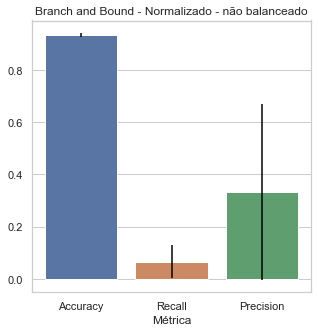

In [26]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Branch and Bound - Normalizado - não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Branch_and_Bound-Normalizado-nao_balanceado-RandomForestsClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

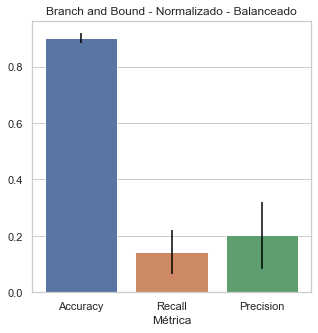

In [27]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Branch and Bound - Normalizado - Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Branch_and_Bound-Normalizado-balanceado-RandomForestsClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [28]:
path_to_save = '../../model_results/'
score_min_unbalanced = pd.DataFrame([acc_min_unbalanced, rec_min_unbalanced, pre_min_unbalanced]).rename(columns = {0: 'Score'})
score_max_unbalanced =  pd.DataFrame([acc_max_unbalanced, rec_max_unbalanced, pre_max_unbalanced]).rename(columns = {0: 'Score'})
score_min_balanced = pd.DataFrame([acc_min_balanced, rec_min_balanced, pre_min_balanced]).rename(columns = {0: 'Score'})
score_max_balanced =  pd.DataFrame([acc_max_balanced, rec_max_balanced, pre_max_balanced]).rename(columns = {0: 'Score'})

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    'RandomForestClassifier',
    '9',
    'Branch and Bound Desbalanceado - Normalizado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    'RandomForestClassifier',
    '9',
    'Branch and Bound Balanceado - Normalizado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_balanced[metrica],score_min_balanced.loc[metrica]['Score'], score_max_balanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Algoritmo,Atividade,Condicao,Melhores_Params,Metrica,Valor,Intervalo_Confianca
0,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Accuracy,0.896129,"[0.896, 0.857, 0.935]"
1,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Recall,0.02,"[0.020, -0.025, 0.065]"
2,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Precision,0.00666667,"[0.007, -0.008, 0.022]"
3,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Accuracy,0.690109,"[0.690, 0.473, 0.907]"
4,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Recall,0.216667,"[0.217, -0.049, 0.482]"
5,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Precision,0.0492712,"[0.049, -0.024, 0.123]"
6,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Accuracy,0.822886,"[0.823, 0.784, 0.862]"
7,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Recall,0.153333,"[0.153, 0.034, 0.272]"
8,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Precision,0.0906421,"[0.091, 0.013, 0.169]"
9,Naive Bayes,6,Branch and Bound Balanceado - Normalizado,0.1,Accuracy,0.512845,"[0.513, 0.416, 0.610]"


Resultados salvos com sucesso
